# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.84KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

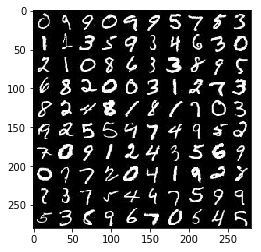

In [6]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

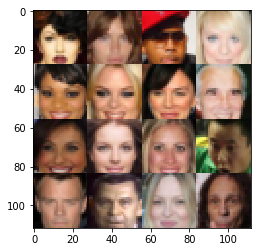

In [8]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse = reuse):
        # Build input layer (input_layer 28x28)
        #14x14x64
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = "same")
        x1 = tf.maximum(alpha * x1, x1)
        
        #7x7x128
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = "same")
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha * x2, x2)
        
        #4x4x256
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2, padding = "same")
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)
                
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)       

    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("generator", reuse = not is_train):
        # First fully connected layer
        #2x2x512
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        #7x7x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = "valid")
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        #14x14x128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = "same")
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        #28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding = "same")
        
        output = tf.tanh(logits)        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
   
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    if steps % show_every == 0:
                        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 6.0221
Epoch 1/2... Discriminator Loss: 2.3314... Generator Loss: 16.5006
Epoch 1/2... Discriminator Loss: 2.7821... Generator Loss: 14.3645
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 1.5337
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 3.1638
Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 4.7996
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 2.9197
Epoch 1/2... Discriminator Loss: 3.0515... Generator Loss: 9.9540
Epoch 1/2... Discriminator Loss: 0.5437... Generator Loss: 2.9129
Epoch 1/2... Discriminator Loss: 0.5027... Generator Loss: 3.9054


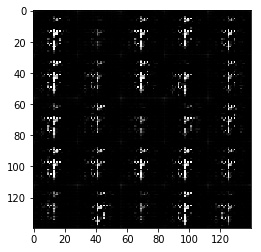

Epoch 1/2... Discriminator Loss: 0.4131... Generator Loss: 3.8453
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 3.0386
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 2.4165
Epoch 1/2... Discriminator Loss: 0.5017... Generator Loss: 3.0862
Epoch 1/2... Discriminator Loss: 0.5411... Generator Loss: 4.0948
Epoch 1/2... Discriminator Loss: 0.5078... Generator Loss: 2.6616
Epoch 1/2... Discriminator Loss: 0.4967... Generator Loss: 3.1319
Epoch 1/2... Discriminator Loss: 0.4283... Generator Loss: 4.3246
Epoch 1/2... Discriminator Loss: 0.4815... Generator Loss: 2.9113


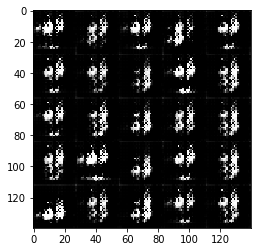

Epoch 1/2... Discriminator Loss: 0.3888... Generator Loss: 3.9335
Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 5.2276
Epoch 1/2... Discriminator Loss: 0.3595... Generator Loss: 4.4400
Epoch 1/2... Discriminator Loss: 0.3798... Generator Loss: 3.4724
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 3.8177
Epoch 1/2... Discriminator Loss: 0.6319... Generator Loss: 5.6289
Epoch 1/2... Discriminator Loss: 0.5850... Generator Loss: 2.4258
Epoch 1/2... Discriminator Loss: 0.4426... Generator Loss: 3.2931
Epoch 1/2... Discriminator Loss: 0.4466... Generator Loss: 3.1260
Epoch 1/2... Discriminator Loss: 0.4362... Generator Loss: 3.2607


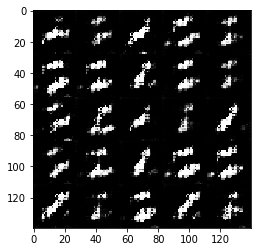

Epoch 1/2... Discriminator Loss: 0.4883... Generator Loss: 2.9394
Epoch 1/2... Discriminator Loss: 0.3976... Generator Loss: 4.1386
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 3.9413
Epoch 1/2... Discriminator Loss: 0.7270... Generator Loss: 5.1224
Epoch 1/2... Discriminator Loss: 0.5108... Generator Loss: 2.5218
Epoch 1/2... Discriminator Loss: 0.6140... Generator Loss: 3.6158
Epoch 1/2... Discriminator Loss: 0.4958... Generator Loss: 2.7960
Epoch 1/2... Discriminator Loss: 0.4525... Generator Loss: 3.3412
Epoch 1/2... Discriminator Loss: 0.4129... Generator Loss: 3.4615
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 4.0401


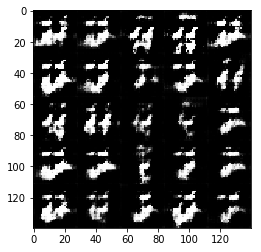

Epoch 1/2... Discriminator Loss: 0.4318... Generator Loss: 3.4629
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 1.9477
Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 2.4795
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 2.2117
Epoch 1/2... Discriminator Loss: 0.5354... Generator Loss: 2.5980
Epoch 1/2... Discriminator Loss: 0.5931... Generator Loss: 3.1064
Epoch 2/2... Discriminator Loss: 0.6172... Generator Loss: 2.0422
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 3.5348
Epoch 2/2... Discriminator Loss: 0.6584... Generator Loss: 2.0615
Epoch 2/2... Discriminator Loss: 0.4983... Generator Loss: 2.5747


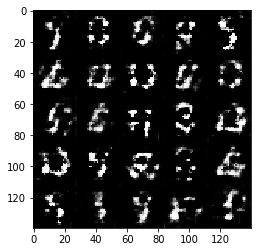

Epoch 2/2... Discriminator Loss: 0.5523... Generator Loss: 2.4625
Epoch 2/2... Discriminator Loss: 0.5143... Generator Loss: 3.4063
Epoch 2/2... Discriminator Loss: 0.6860... Generator Loss: 1.9062
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 2.7745
Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 2.4245
Epoch 2/2... Discriminator Loss: 0.5755... Generator Loss: 2.2940
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 2.5882
Epoch 2/2... Discriminator Loss: 0.7258... Generator Loss: 1.8581
Epoch 2/2... Discriminator Loss: 0.6728... Generator Loss: 1.9699
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.3535


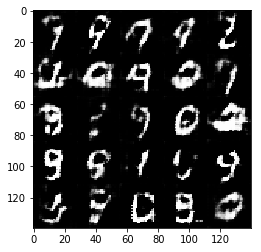

Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 2.1873
Epoch 2/2... Discriminator Loss: 0.6524... Generator Loss: 2.2075
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 1.4660
Epoch 2/2... Discriminator Loss: 0.6446... Generator Loss: 2.9958
Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.9381
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 2.7789
Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 2.9095
Epoch 2/2... Discriminator Loss: 0.9166... Generator Loss: 2.8874
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.0264
Epoch 2/2... Discriminator Loss: 0.6373... Generator Loss: 2.0505


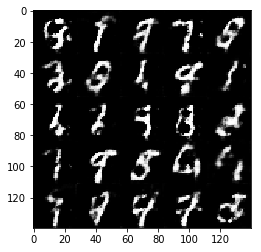

Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 2.5393
Epoch 2/2... Discriminator Loss: 1.0344... Generator Loss: 3.1711
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.4310
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 1.3989
Epoch 2/2... Discriminator Loss: 1.3973... Generator Loss: 0.7070
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 2.9435
Epoch 2/2... Discriminator Loss: 0.6837... Generator Loss: 1.8510
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.5318
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.6936
Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.9217


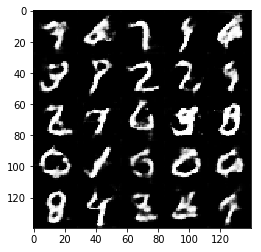

Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 1.1727
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.7415
Epoch 2/2... Discriminator Loss: 0.6961... Generator Loss: 2.0244
Epoch 2/2... Discriminator Loss: 0.6523... Generator Loss: 1.9586
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 2.6739
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 1.0103
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 1.8134
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.3709
Epoch 2/2... Discriminator Loss: 1.7453... Generator Loss: 0.4857
Epoch 2/2... Discriminator Loss: 0.9681... Generator Loss: 1.0371


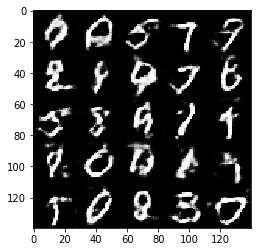

Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.7604
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 3.5762


In [18]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 14.7069
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 12.9185
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 15.6482
Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 8.3593
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.7509
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 2.9142
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.7958
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 1.6661
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.9996


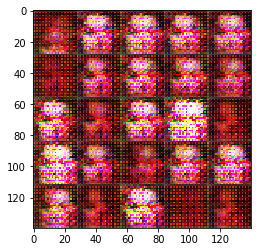

Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 2.6825
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.9816
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 2.9973
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.8266
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 3.1759
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 4.0371
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 4.1088
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 0.5025... Generator Loss: 2.5428
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 4.2778


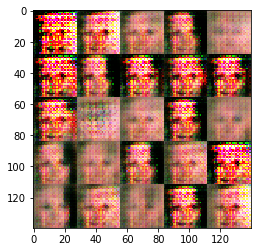

Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 2.7444
Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 2.4237
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 4.5286
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 2.4859
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 3.1418... Generator Loss: 5.7496
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.4677
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.9365
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 2.1445


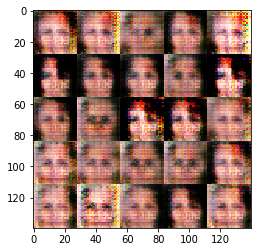

Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.8376
Epoch 1/1... Discriminator Loss: 2.0719... Generator Loss: 4.9179
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.6919
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 2.3881
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 2.0873
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 1.6236
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 3.5429


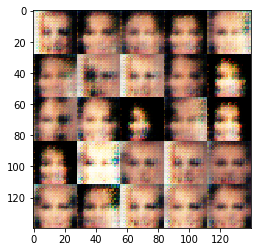

Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.6624
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.6974
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 1.9863
Epoch 1/1... Discriminator Loss: 2.0892... Generator Loss: 0.2619
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.4352


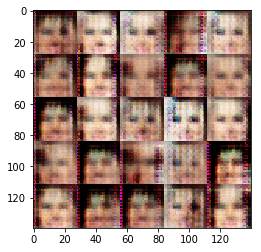

Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.7543
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 2.5056
Epoch 1/1... Discriminator Loss: 2.1747... Generator Loss: 2.9459
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 2.9594
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 1.8456


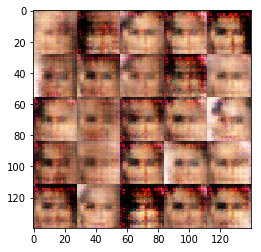

Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.3978
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.7505
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.7460
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7914


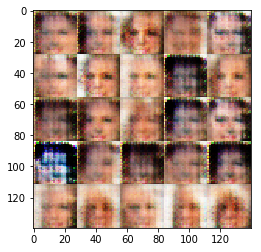

Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.5322
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.7605
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.5431
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.5564


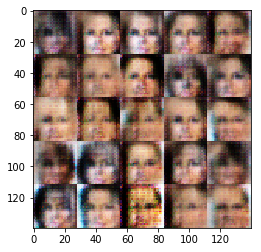

Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 2.0161
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.4444
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.9834... Generator Loss: 3.0046
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.8515


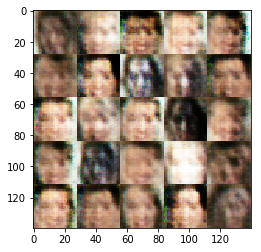

Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 2.8004... Generator Loss: 0.1253
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.7824
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.8951
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.9391
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 2.0638
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 2.5290
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 1.9349... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.6836


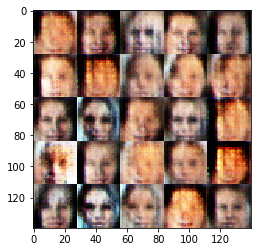

Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 2.2316
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.7292
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.2950
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.4962
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.2492
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.7610
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.9168
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.0283


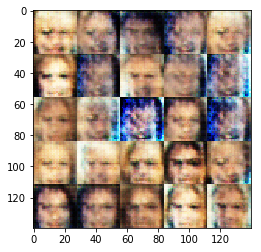

Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 1.4507
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 2.2943
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 2.3692
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.2288


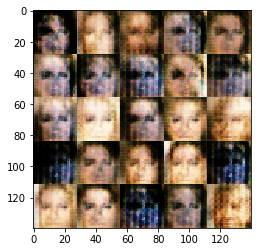

Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.9781
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 2.8292
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.3010
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.8082
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.3119


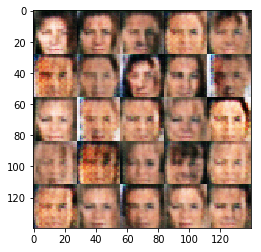

Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.3070
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.8803
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.5953
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7802


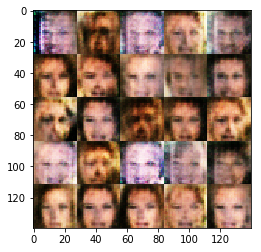

Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 2.5255
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.8402
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.4379
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 2.2363
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.7853


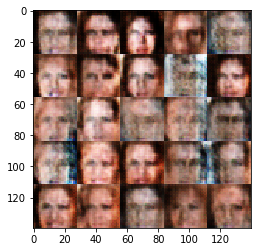

Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 2.5915
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.7881
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.4554


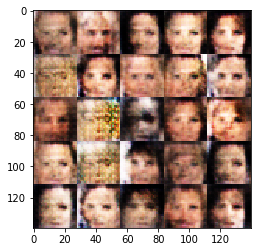

Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 2.8184
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 2.1541
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 2.4642
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.4586
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.4210


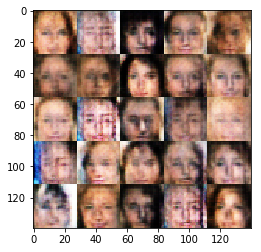

Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 2.8341
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.4001
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.6164
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.6215
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 2.0493
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.2609


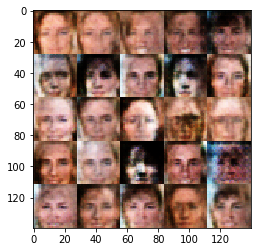

Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 2.4637
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.4866
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.2661
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 3.3055
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.8984


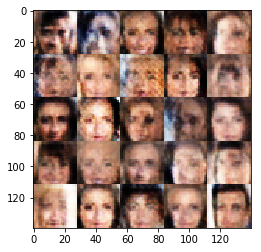

Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 2.6557
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 2.0051
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.3936
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.5101
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.4800
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.3024


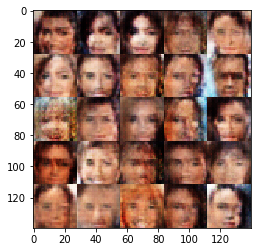

Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.7378
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.6549
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.5591
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.5116
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.7435


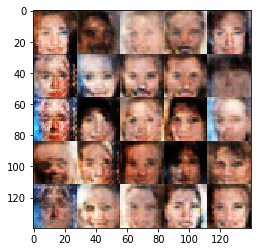

Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 2.0022
Epoch 1/1... Discriminator Loss: 1.6291... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.9316
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.5885
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.0744


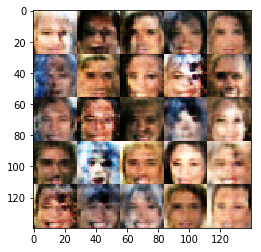

Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.4973
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.8852
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.8650
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.8840
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.0953


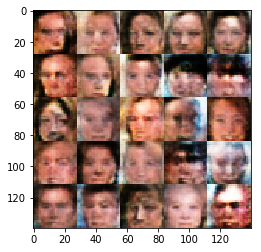

Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.8505
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.3172
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 2.1823
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.4627
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.3646


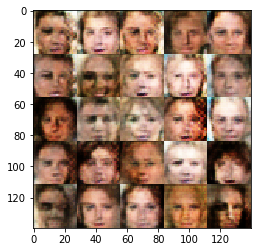

Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.6263
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 2.1781
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 2.0517
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.5906
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.3275


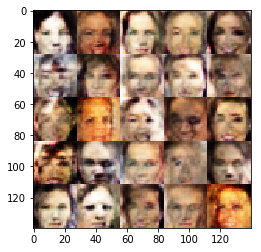

Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.2641
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.7655
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 2.1886
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.5592
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.7142
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.1136


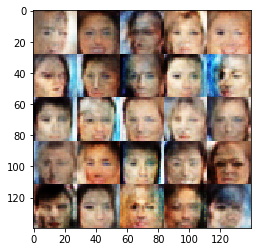

Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 2.2213
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 2.1546
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.7778
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.7388
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 3.0403
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.4875


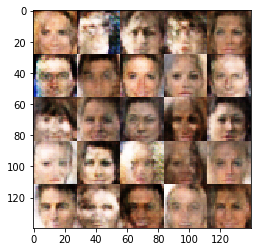

Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.6693
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.3267
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.3163
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.0803


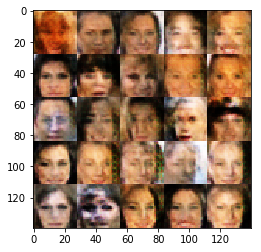

Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.7046
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 3.4210
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 2.1266
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 2.0007
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.2693


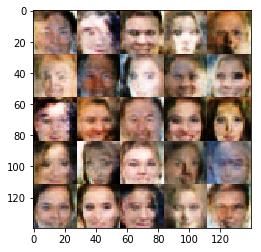

Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 2.0259
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 2.4185
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.9194


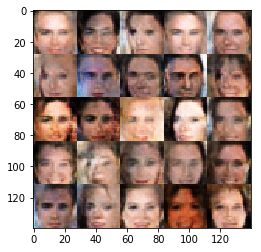

Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.7945
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 2.6395
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.9120
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.8596


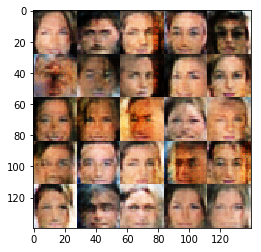

Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 2.3946
Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.9046
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.7936


In [19]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.